# 実験を開始する

実験リポジトリの新規作成と実験記録に必要な実験パッケージの用意によって実験の作成と開始をサポートします。  
実験リポジトリは、研究プロジェクトのリポジトリとは別のリポジトリですが、研究リポジトリのexperimentsフォルダ配下に子関係として追加されます。  
上から順番に実行してください。  
2回目以降の実行の場合、このセルが選択された状態で画面上部に表示される以下のボタンをクリックしてから実行して下さい。
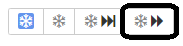

## 1. 開始する実験の実験リポジトリ名を入力する

以下のセルを実行し、表示されるテキストボックスに作成したい実験リポジトリ名を半角英数字で入力してください。  
データガバナンス機能にすでに存在するリポジトリ名のリポジトリは作成いただけません。実験名など分かりやすい名前をご記入ください。  
入力した実験リポジトリ名の履歴をこのノートブックに保存したい場合は、実行後にセルの左側に表示されるピンマークをクリックしてください。  
※入力値に誤りがある場合、もう一度実行することで訂正ができます。

In [ ]:
from IPython.display import clear_output
repository_title = input("リポジトリ名：")
clear_output()
print("作成したリポジトリ名：",repository_title)

## 2. 実験リポジトリを作成する

先ほど入力いただいた名前の実験用リポジトリをデータガバナンス機能に作成します。  
そのために、以下のセルを実行し、表示されるテキストボックスにデータガバナンス機能のユーザ名とパスワードを入力してください。  
この情報は認証のために利用します。

In [ ]:
import json
import os
os.chdir('..')

from util.scripts import utils

# 以下の認証の手順で用いる、
# GINのドメイン名等をパラメタファイルから取得する
params = {}
with open(utils.fetch_param_file_path(), mode='r') as f:
    params = json.load(f)

In [ ]:
# リポジトリ作成のためのユーザ認証
import os
import time
import getpass
import requests

from IPython.display import clear_output
from requests.auth import HTTPBasicAuth
from http import HTTPStatus

# 正常に認証が終わるまで繰り返し
while True:
    name = input("ユーザー名：")
    password = getpass.getpass("パスワード：")
    clear_output()
    
    # GIN API Basic Authentication
    # refs: https://docs.python-requests.org/en/master/user/authentication/
    
    # 既存のトークンがあるか確認する
    response = requests.get(params['siblings']['ginHttp']+'api/v1/users/' + name + '/tokens', auth=(name, password))
    tokens = response.json()

    # 既存のトークンがなければ作成する
    if len(tokens) < 1:
        response = requests.post(params['siblings']['ginHttp']+'api/v1/users/' + name + '/tokens', data={"name": "system-generated"} ,auth=(name, password))

    if response.status_code == HTTPStatus.OK or HTTPStatus.CREATED:
        tokens = response.json()
        clear_output()
        print("認証が正常に完了しました。次の手順へお進みください。")
        break
    else:
        clear_output()
        print("ユーザ名、またはパスワードが間違っています。\n恐れ入りますがもう一度ご入力ください。")

In [ ]:
# GIN APIでリポジトリを作成する
import requests

create_repo = requests.post(
                # FIXME: ドメイン名のハードコーディング
                params['siblings']['ginHttp']+'api/v1/user/repos?token=' + tokens[0]['sha1'],
                data={
                    "name": repository_title,
                    "auto_init": False
                }
                )
print(create_repo)

## 3. 実験記録管理のための準備を行う

### - 3.1 実験リポジトリに実験パッケージを用意する

In [ ]:
%%bash
#!/bin/bash
if [ ! -d ~/.tmp/ ]; then
    # .tmpフォルダを作成
    mkdir ~/.tmp
fi

if [ ! -d ~/.tmp/repository_title ]; then
    # 実験タイトル名のフォルダを作成
    mkdir ~/.tmp/repository_title
fi

In [ ]:
# urlを生成する
remote_url = params['siblings']['ginSsh']+name+'/'+repository_title+'.git'
remote_http_url = params['siblings']['ginHttp']+name+'/'+repository_title+'.git'

# 実験パッケージを用意する
!cp -r ~/WORKFLOW/PACKAGE/. ~/.tmp/$repository_title/

# dataset化してsiblingを設定する
%cd ~/.tmp/$repository_title
!datalad create --force .
!datalad siblings add -s "gin" --url $remote_url

In [ ]:
# データガバナンス機能に同期する
import papermill as pm
pm.execute_notebook(
    '/home/jovyan/WORKFLOW/FLOW/util/base_datalad_save_push.ipynb',
    '/home/jovyan/.local/push_log.ipynb',
    parameters = dict(SAVE_MESSAGE = '実験パッケージの用意', PATH='/home/jovyan/.tmp/'+repository_title, TO_GIT = True)
)

In [ ]:
# 実験リポジトリをexperiments配下にクローンする
%cd ~/
!datalad clone -d . $remote_http_url \./experiments/$repository_title

### - 3.2 pipeline.jsonに実験名を追記する

In [ ]:
import json

with open('/home/jovyan/experiments/pipeline.json', 'r') as f:
    pipeline = json.load(f)

pipeline.append(repository_title)

with open('/home/jovyan/experiments/pipeline.json', 'w') as f:
    json.dump(pipeline, f, indent = 4)

## 4. 実行結果をデータガバナンス機能に同期する

ここまでの内容を保存し、データガバナンス機能に同期します。  
以下のセルを実行してください。

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

In [ ]:
import papermill as pm

%cd ~/

pm.execute_notebook(
    'WORKFLOW/FLOW/util/base_datalad_save_push.ipynb',
    '/home/jovyan/.local/push_log.ipynb',
    parameters = dict(SAVE_MESSAGE = '実験用リポジトリの作成', IS_RECURSIVE = False, TO_GIT = True)#, PATH = '/home/jovyan/experiments/'+repository_title)
)

## 5. 実験リポジトリにアクセスして実験を開始する

以下のセルを実行した後に出力されるリンクをクリックして実験に移ってください。 

In [ ]:
import urllib

print(
    "https://binder.cs.rcos.nii.ac.jp/v2/git/" + urllib.parse.quote(remote_http_url, safe='') + "/HEAD?filepath=experiment.ipynb"
)

## 6. ワークフロー機能トップページに遷移する

続けてワークフロー機能を実行する場合は、[こちら](../base_FLOW.ipynb)からトップページに遷移できます。  